Running training jobs on the cloud with Raster Vision and SageMaker
===

In this notebook, we configure a training job as a Raster Vision pipeline and then execute it on SageMaker.

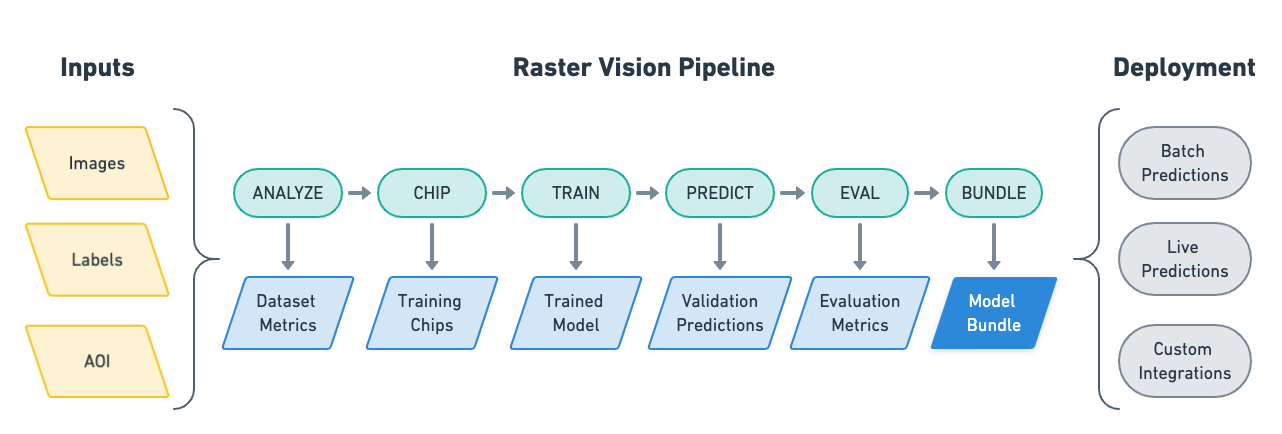

<hr style="border: 2px solid gray">

In [ ]:
your_name = 'test'

# Define PipelineConfig(s)

In [ ]:
from os.path import join
from pathlib import Path

import albumentations as A
from sklearn.model_selection import KFold

from rastervision.pipeline.file_system.utils import (json_to_file, list_paths)
from rastervision.core.data import (
    ClassConfig, ClassInferenceTransformerConfig, DatasetConfig,
    GeoJSONVectorSourceConfig, MultiRasterSourceConfig, RasterioSourceConfig,
    RasterizedSourceConfig, RasterizerConfig, SceneConfig,
    SemanticSegmentationLabelSourceConfig)
from rastervision.core.rv_pipeline import (SemanticSegmentationConfig,
                                           SemanticSegmentationPredictOptions,
                                           WindowSamplingConfig,
                                           WindowSamplingMethod)
from rastervision.pytorch_learner import (ExternalModuleConfig,
                                          SemanticSegmentationGeoDataConfig,
                                          SemanticSegmentationModelConfig,
                                          PlotOptions, SolverConfig)
from rastervision.pytorch_backend import PyTorchSemanticSegmentationConfig

In [ ]:
img_dir = 's3://ml-workshop/sandstorm/data/img/VIIRS_SNPP_CorrectedReflectance_TrueColor/'
label_dir = 's3://ml-workshop/sandstorm/data/labels_geojson/'

In [ ]:
out_dir = f's3://ml-workshop/2024_05_15/{your_name}/sandstorm-training/'
out_dir

In [ ]:
class_config = ClassConfig(names=['background', 'dust'],
                           colors=['lightgray', 'maroon'],
                           null_class='background')

In [ ]:
label_uris = sorted(list_paths(label_dir, ext='.json'))
len(label_uris)

In [ ]:
img_uris = [join(img_dir, f'{Path(uri).stem}.tif') for uri in label_uris]
len(img_uris)

In [ ]:
def make_scene(img_uri: str, 
               label_uri: str, 
               class_config: ClassConfig, 
               extra_raster_uris: list[str] | None = None):
    if extra_raster_uris is None:
        raster_source = RasterioSourceConfig(uris=img_uri)
    else:
        raster_uris = [img_uri] + extra_raster_uris
        raster_sources = [RasterioSourceConfig(uris=uri) for uri in raster_uris]
        raster_source = MultiRasterSourceConfig(raster_sources=raster_sources)
    label_vector_source = GeoJSONVectorSourceConfig(
        uris=label_uri,
        transformers=[
            ClassInferenceTransformerConfig(
                  default_class_id=class_config.get_class_id('background'),
                  class_name_mapping=dict(dust_over_land='dust', dust_over_water='dust'),
              )
        ]
    )
    label_raster_source = RasterizedSourceConfig(
        vector_source=label_vector_source,
        rasterizer_config=RasterizerConfig(
            background_class_id=class_config.get_class_id('background'),
            all_touched=True,
        )
    )
    label_source = SemanticSegmentationLabelSourceConfig(
        raster_source=label_raster_source)
    scene = SceneConfig(
        id=Path(img_uri).stem,
        raster_source=raster_source, 
        label_source=label_source,
    )
    return scene

In [ ]:
scenes = [
    make_scene(img_uri, label_uri, class_config) 
    for img_uri, label_uri in zip(img_uris, label_uris)
]

In [ ]:
aug_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])


def make_pipeline(out_uri: str, scene_dataset: 'DatasetConfig',
                  class_config: 'ClassConfig', chip_sz: int, img_sz: int,
                  num_channels: int, channel_display_groups: dict,
                  solver: 'SolverConfig'):

    window_sampling_opts = {}
    # set window configs for training scenes
    for s in scene_dataset.train_scenes:
        window_sampling_opts[s.id] = WindowSamplingConfig(
            method=WindowSamplingMethod.random,
            size_lims=(chip_sz, chip_sz + 1),
            size=img_sz,
            max_windows=16,
            padding=0,
        )

    # set window configs for validation scenes
    for s in scene_dataset.validation_scenes:
        window_sampling_opts[s.id] = WindowSamplingConfig(
            method=WindowSamplingMethod.sliding,
            size=chip_sz,
            stride=(chip_sz // 2))

    data = SemanticSegmentationGeoDataConfig(
        scene_dataset=scene_dataset,
        sampling=window_sampling_opts,
        img_sz=img_sz,
        img_channels=num_channels,
        num_workers=4,
        aug_transform=A.to_dict(aug_transform),
        plot_options=PlotOptions(
            channel_display_groups=channel_display_groups))

    model = SemanticSegmentationModelConfig(
        external_def=ExternalModuleConfig(github_repo='AdeelH/pytorch-fpn:0.3',
                                          name='fpn',
                                          entrypoint='make_fpn_resnet',
                                          entrypoint_kwargs={
                                              'name': 'resnet18',
                                              'fpn_type': 'panoptic',
                                              'num_classes': len(class_config),
                                              'fpn_channels': 128,
                                              'in_channels': num_channels,
                                              'out_size': (img_sz, img_sz),
                                          }))

    backend = PyTorchSemanticSegmentationConfig(
        data=data,
        model=model,
        solver=solver,
        log_tensorboard=False,
        run_tensorboard=False,
    )

    predict_options = SemanticSegmentationPredictOptions(chip_sz=chip_sz)

    pipeline = SemanticSegmentationConfig(root_uri=out_uri,
                                          dataset=scene_dataset,
                                          backend=backend,
                                          predict_options=predict_options)

    return pipeline

In [ ]:
num_splits = 2
kf = KFold(n_splits=num_splits)

split_pipelines = [None] * num_splits
for split_num, (train_inds, val_inds) in enumerate(kf.split(img_uris)):
    scene_dataset = DatasetConfig(
        class_config=class_config,
        train_scenes=[scenes[i] for i in train_inds],
        validation_scenes=[scenes[i] for i in val_inds],
    )
    split_out_dir = join(out_dir, f'split-{split_num}')
    split_pipelines[split_num] = make_pipeline(
        out_uri=split_out_dir,
        scene_dataset=scene_dataset,
        class_config=class_config,
        chip_sz=512,
        img_sz=256,
        num_channels=3,
        channel_display_groups={
            'RGB': [0, 1, 2],
        },
        solver=SolverConfig(batch_sz=16, lr=1e-4),
    )

In [ ]:
pipelines_json_path = join('data', 'train', Path(out_dir).stem, 'configs.json')
pipelines_json_path

In [ ]:
json_to_file([p.dict() for p in split_pipelines], pipelines_json_path)

---

# Run pipeline on SageMaker

Set SageMaker options via environment variables:

In [ ]:
%env SAGEMAKER_ROLE=SageMaker-GeoMLWorkshopParticipant
%env SAGEMAKER_CPU_IMAGE=992382462803.dkr.ecr.us-east-1.amazonaws.com/raster-vision-pytorch
%env SAGEMAKER_CPU_INSTANCE_TYPE=ml.p3.2xlarge
%env SAGEMAKER_GPU_IMAGE=992382462803.dkr.ecr.us-east-1.amazonaws.com/raster-vision-pytorch
%env SAGEMAKER_GPU_INSTANCE_TYPE=ml.p3.2xlarge
%env SAGEMAKER_USE_SPOT_INSTANCES=no

Alternatively, you can have them in a `~/.rastervision/default` file like so:
```
[SAGEMAKER]
role=SageMaker-GeoMLWorkshopParticipant
cpu_image=992382462803.dkr.ecr.us-east-1.amazonaws.com/raster-vision-pytorch
cpu_instance_type=ml.p3.2xlarge
gpu_image=992382462803.dkr.ecr.us-east-1.amazonaws.com/raster-vision-pytorch
gpu_instance_type=ml.p3.2xlarge
use_spot_instances=no
```

In [ ]:
!rastervision run sagemaker {pipelines_json_path} train --pipeline-run-name ml-workshop-{your_name}

---

For debugging:

In [ ]:
!aws sagemaker describe-pipeline-execution --pipeline-execution-arn <PipelineExecutionArn>

In [ ]:
!aws sagemaker list-pipeline-execution-steps --pipeline-execution-arn <PipelineExecutionArn>

In [ ]:
!aws sagemaker list-training-jobs

In [ ]:
!aws sagemaker help

---